In [1]:
import os
import numpy as np
import pickle
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing, model_selection, metrics, decomposition
from zipfile import ZipFile
import sagemaker

%matplotlib inline

In [2]:
# Setting initial values
data_dir = 'input_data'
file_name = "santander-value-prediction-challenge.zip"
seed=0
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
data_s3_prefix = 'santander_project/data'

## Initial Examination of Training Data

In [3]:
# Unizipping train and test datasets to local drive
with ZipFile(file_name, 'r') as zip_file: 
    for file in zip_file.namelist():
        if os.path.exists(data_dir + r'/' + file):
            pass
        else:
            zip_file.extract(file, data_dir)
            

In [4]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), index_col='ID')

In [ ]:
train_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df.columns

In [ ]:
# Looking for missing values
list(filter(lambda x: x < len(train_df.columns), train_df.apply(lambda x: x.count(), axis=1)))

Most data seems to consist of zeros, with some apparently continuous values. Feature names do not contain any relevant information. Checking whether there are any columns with probably binary categorical data.

In [ ]:
binary_columns = bool_cols = [col for col in train_df 
             if np.isin(train_df[col].dropna().unique(), [0, 1]).all()]

In [ ]:
train_df[binary_columns].describe()

The values that come up appear to only have one value. The presence of constants may introduce bias into algorithm training, and so i will drop them from both datasets.

In [5]:
constant_cols = list(train_df.loc[:, train_df.nunique() == 1].columns)

In [6]:
train_df = train_df.drop(constant_cols, axis=1)

In [7]:
train_df.to_csv(os.path.join(data_dir, 'train.csv'))

In [8]:
# Editing test file. Not the prettiest approach, but making do with limited RAM.

chunksize=2000
header=True

for chunk in pd.read_csv(os.path.join(data_dir, 'test.csv'), chunksize=chunksize, index_col='ID'):
    chunk = chunk.drop(constant_cols, axis=1)
    chunk.to_csv(os.path.join(data_dir, 'test_trimmed.csv'), mode='a', header=header)
    header=False
    
os.remove(os.path.join(data_dir, 'test.csv'))
os.rename(os.path.join(data_dir, 'test_trimmed.csv'), os.path.join(data_dir, 'test.csv'))

## Examining Target Distribution

Now- examining the characteristics of the target data. There is a very high range of values in the train target, with significant outliers. There is a strong apparent right skew.

In [9]:
train_df.target.describe()

count    4.459000e+03
mean     5.944923e+06
std      8.234312e+06
min      3.000000e+04
25%      6.000000e+05
50%      2.260000e+06
75%      8.000000e+06
max      4.000000e+07
Name: target, dtype: float64

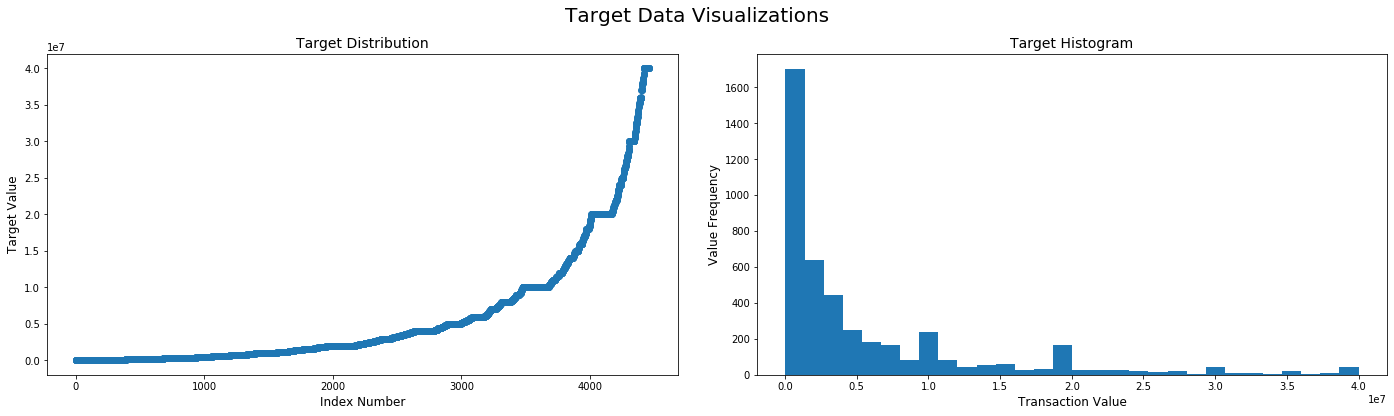

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,6))
ax1.scatter(range(train_df.shape[0]), np.sort(train_df['target'].values))
ax1.set_xlabel('Index Number', fontsize=12)
ax1.set_ylabel('Target Value', fontsize=12)
ax1.set_title("Target Distribution", fontsize=14)

ax2.hist(x=np.sort(train_df.target.values), bins=30)
ax2.set_xlabel('Transaction Value', fontsize=12)
ax2.set_ylabel('Value Frequency', fontsize=12)
ax2.set_title('Target Histogram', fontsize=14)

fig.suptitle('Target Data Visualizations', fontsize=20, y=1)
fig.tight_layout(pad=3.0)

Now, exploring transforms of target data to see if either results in a more normal distribution. Taking a log of the values helps normalize the data some, but a Box-Cox transform appears to do much better.

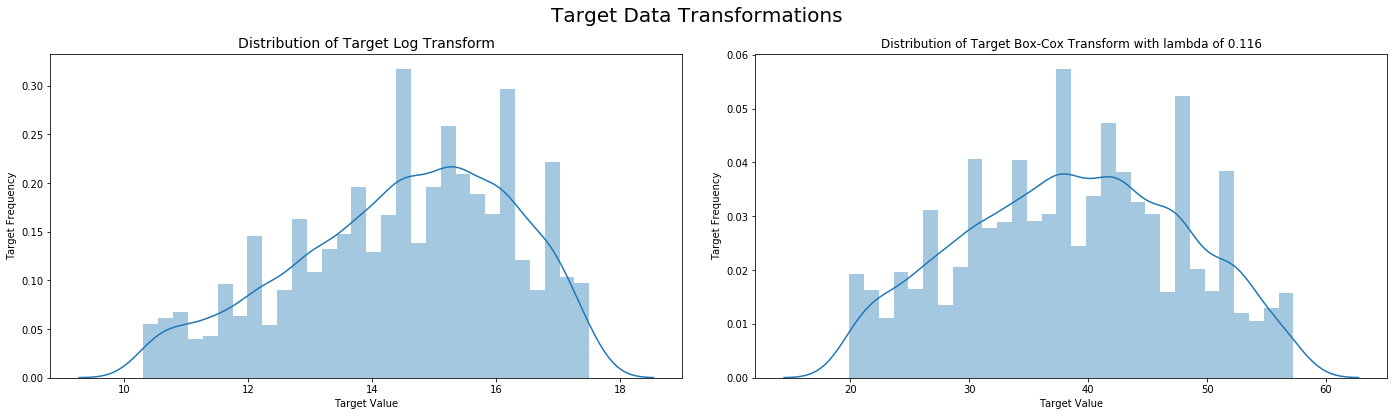

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6)) 
sns.distplot(np.log(train_df.target.values), bins=30, ax=ax1, kde=True).set_title('Distribution of Target Log Transform', fontsize=14)
ax1.set_ylabel('Target Frequency')
ax1.set_xlabel('Target Value')
sns.distplot(stats.boxcox(train_df.target.values)[0], bins=30, ax=ax2, kde=True).set_title('Distribution of Target Box-Cox Transform with lambda of {}'.format(round(stats.boxcox(train_df.target.values)[1], 3)), fontsize=12)
ax2.set_ylabel('Target Frequency')
ax2.set_xlabel('Target Value')
fig.suptitle('Target Data Transformations', fontsize=20, y=1)
fig.tight_layout(pad=3.0)

## Exploring Feature Data Distributions

Quickly examining the distributions of a random subsample of the feature data. Most appear to have a vast majority of zero values.

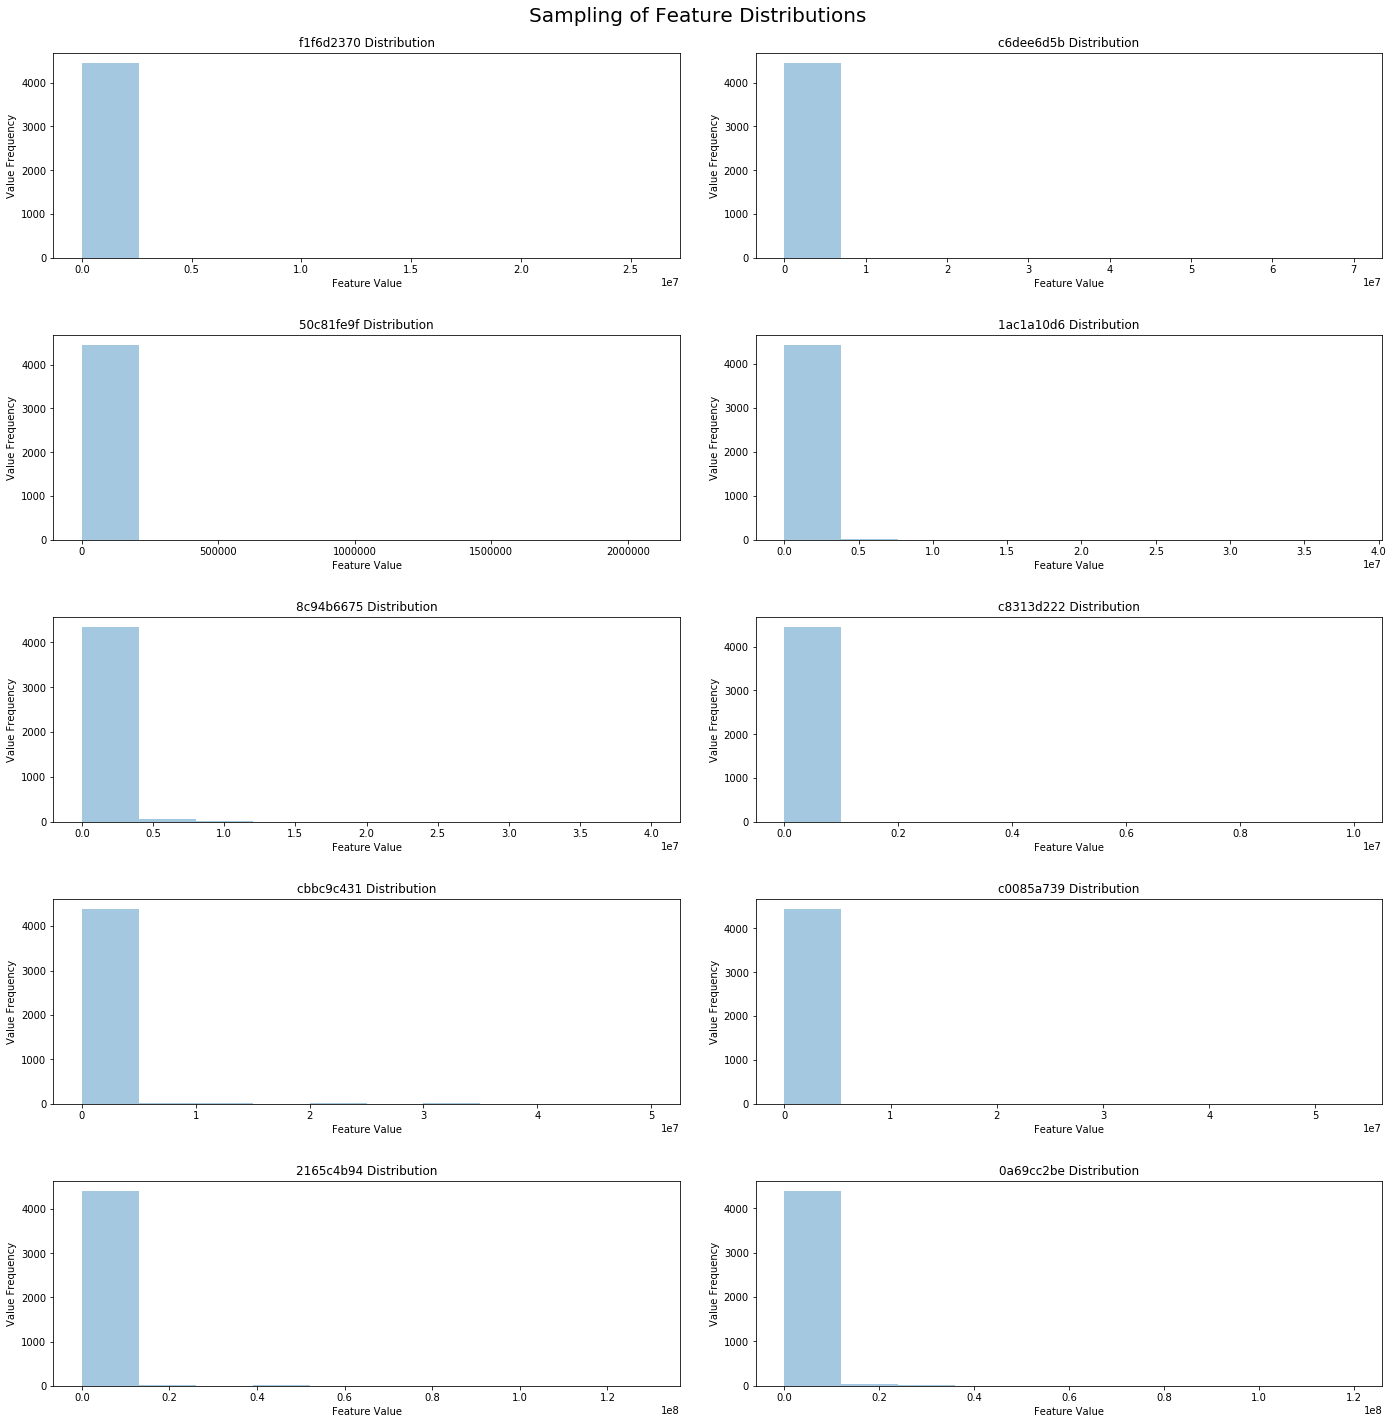

In [12]:
sample=10

fig = plt.figure(figsize=(20, 20)) 

for i, col in enumerate(train_df.iloc[:, 1:].sample(sample, axis=1)):
    ax = fig.add_subplot(5, 2, i+1)
    sns.distplot(train_df[col].values, bins=10, ax = ax, kde=False).set_title('{} Distribution'.format(col), fontsize=12)
    ax.set_ylabel('Value Frequency', fontsize=10)
    ax.set_xlabel('Feature Value', fontsize=10)

fig.suptitle('Sampling of Feature Distributions', fontsize=20, y=1)
fig.tight_layout(pad=3.0)

Now, looking at general relationship between a random subsample of features and the target

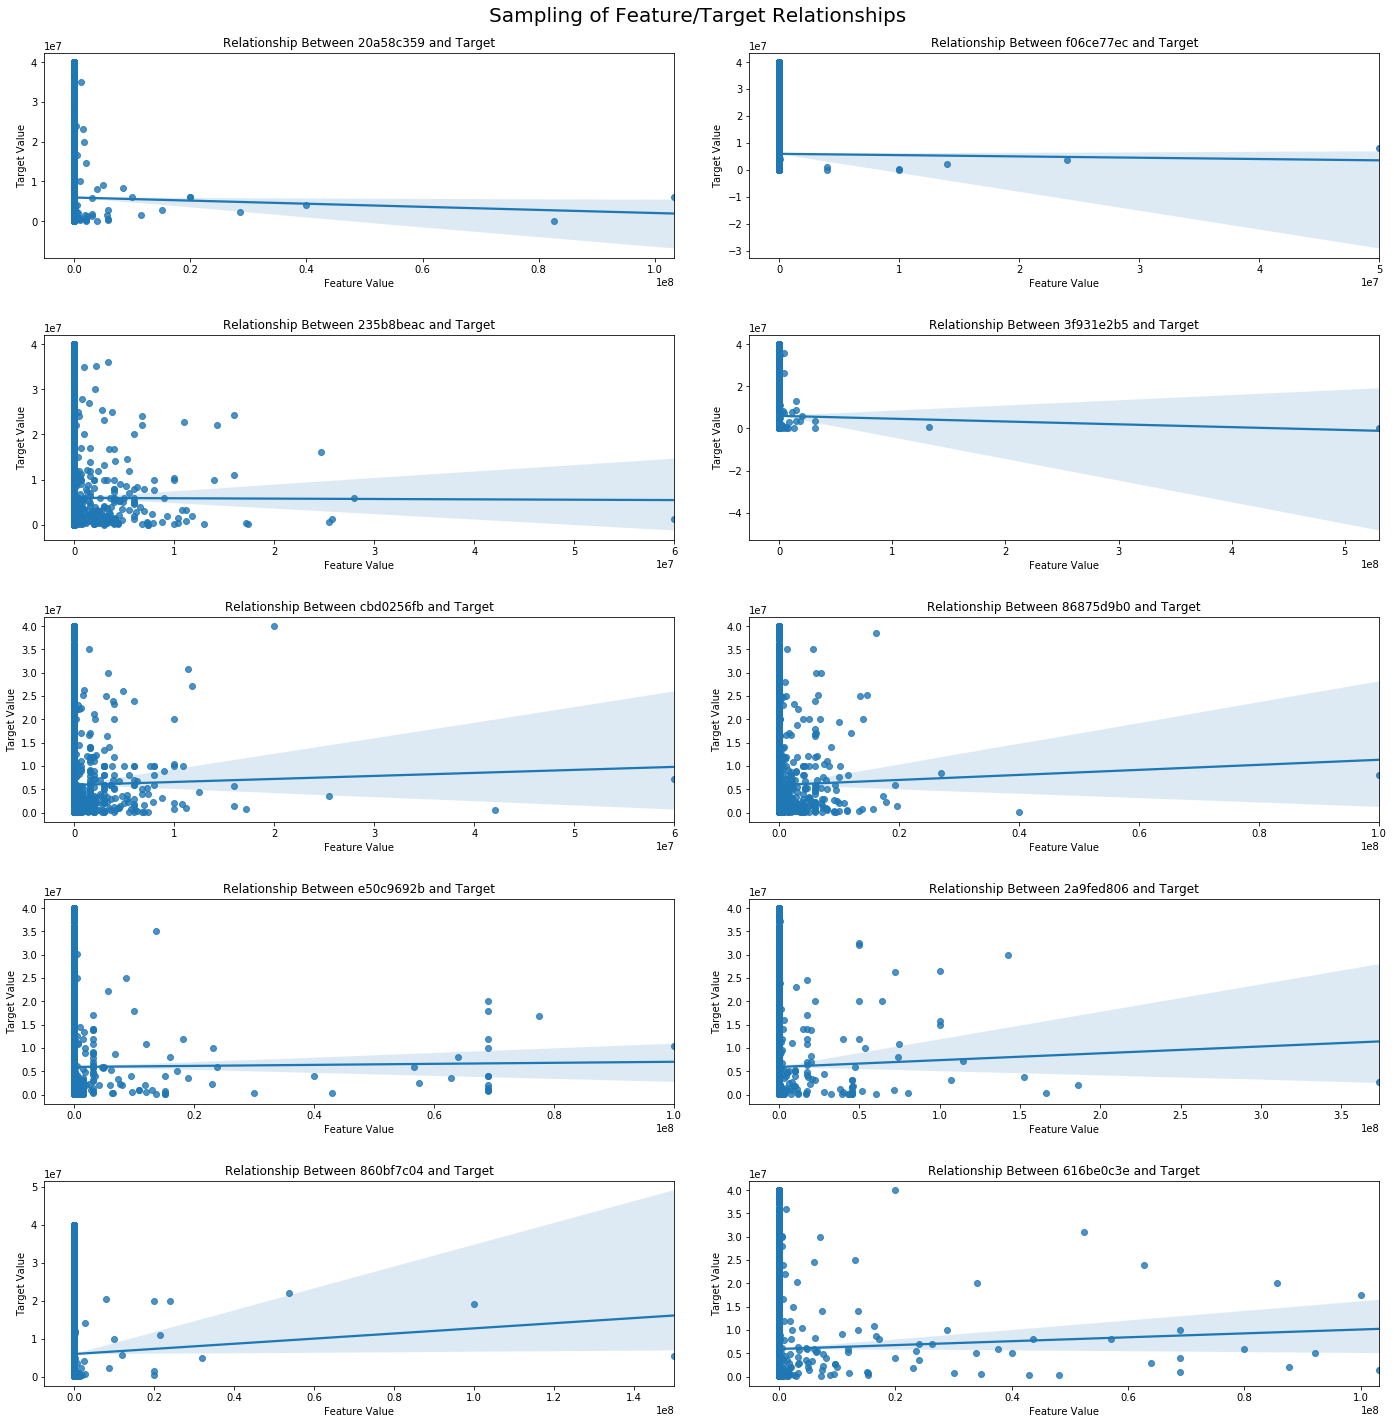

In [13]:
fig = plt.figure(figsize=(20, 20)) 

for i, col in enumerate(train_df.iloc[:, 1:].sample(sample, axis=1)):
    ax = fig.add_subplot(5, 2, i+1)
    sns.regplot(train_df[col].values, train_df['target'], ax = ax, seed=seed).set_title('Relationship Between {} and Target'.format(col), fontsize=12)
    ax.set_ylabel('Target Value', fontsize=10)
    ax.set_xlabel('Feature Value', fontsize=10)
    
fig.suptitle('Sampling of Feature/Target Relationships', fontsize=20, y=1)
fig.tight_layout(pad=3.0)

Next, examining different potential transformations to data

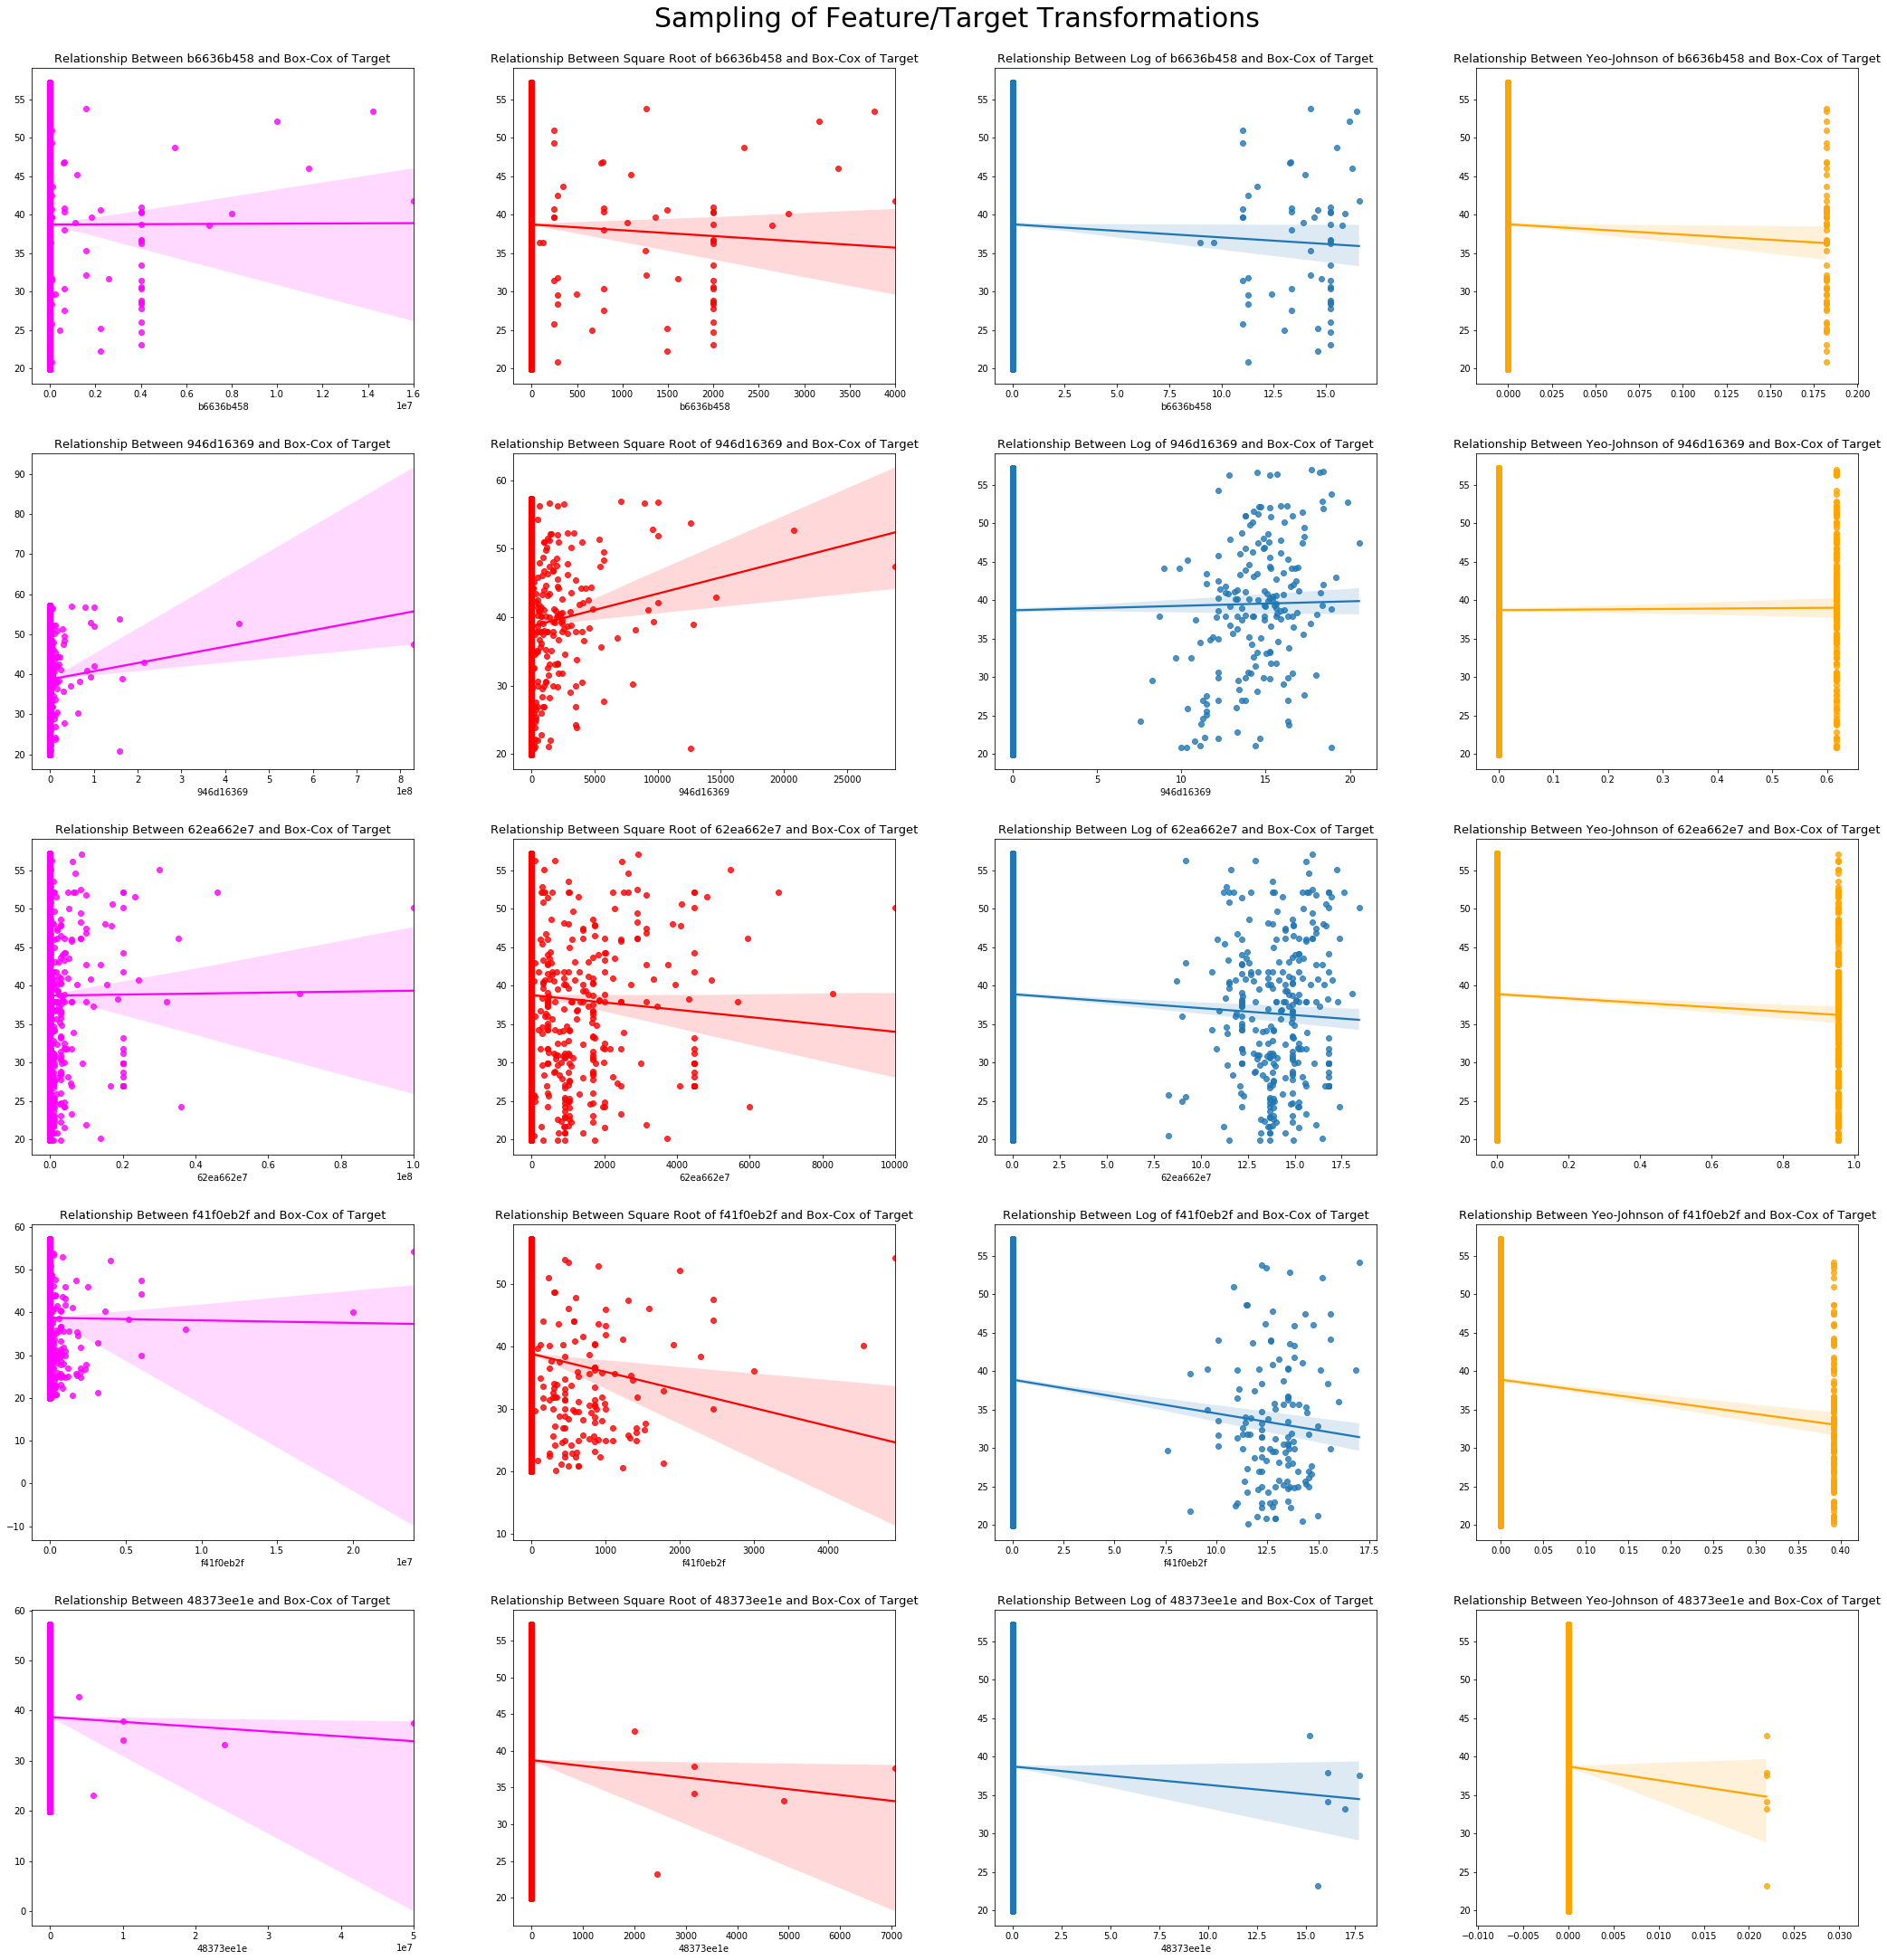

In [14]:
fig, axs = plt.subplots(ncols=4, nrows=int(sample/2), figsize=(30, 30))

for i, col in enumerate(train_df.iloc[:, 1:].sample(int(sample/2), axis=1)):   
    sns.regplot(train_df[col], stats.boxcox(train_df['target'])[0], ax=axs[i, 0], color='magenta').set_title('Relationship Between {} and Box-Cox of Target'.format(col), fontsize=13)
    sns.regplot(np.sqrt(train_df[col]), stats.boxcox(train_df['target'])[0], ax=axs[i, 1], color='red').set_title('Relationship Between Square Root of {} and Box-Cox of Target'.format(col), fontsize=13)
    sns.regplot(np.log(train_df[col]+1), stats.boxcox(train_df['target'])[0], ax=axs[i, 2]).set_title('Relationship Between Log of {} and Box-Cox of Target'.format(col), fontsize=13)
    sns.regplot(stats.yeojohnson(train_df[col])[0], stats.boxcox(train_df['target'])[0], color='orange', ax=axs[i, 3]).set_title('Relationship Between Yeo-Johnson of {} and Box-Cox of Target'.format(col), fontsize=13)

fig.suptitle('Sampling of Feature/Target Transformations', fontsize=30, y=1.01)
fig.tight_layout(pad=3.0)

Because it is visually difficult to determine which transformation works best, i create some basic statistics of the average correlation to the target

In [15]:
baseline_corr = {}
sqrt_corr = {}
log_corr = {}
yj_corr = {}

for col in train_df.iloc[:, 1:].sample(100, axis=1):
    baseline_corr[col] = stats.spearmanr(train_df[col], stats.boxcox(train_df['target'])[0])[0]
    sqrt_corr[col] = stats.spearmanr(np.sqrt(train_df[col]), stats.boxcox(train_df['target'])[0])[0]
    log_corr[col] = stats.spearmanr((train_df[col]+1), stats.boxcox(train_df['target'])[0])[0]
    yj_corr[col] = stats.spearmanr(stats.yeojohnson(train_df[col])[0], stats.boxcox(train_df['target'])[0])[0]

In [16]:
correlations = {}

correlations['No Transformation'] = statistics.mean([abs(x) for x in list(baseline_corr.values())])
correlations['Square Root'] = statistics.mean([abs(x) for x in list(sqrt_corr.values())])
correlations['Log Transformation'] = statistics.mean([abs(x) for x in list(log_corr.values())])
correlations['Yeo-Johnson Transformation'] = statistics.mean([abs(x) for x in list(yj_corr.values())])


correlations

{'No Transformation': 0.024186966734472574,
 'Square Root': 0.024186966734472574,
 'Log Transformation': 0.024186966734472574,
 'Yeo-Johnson Transformation': 0.024241247022486385}

There does not appear to be a clear winner. Next uploading datasets to S3 for later use.

In [ ]:
sagemaker_session.upload_data(path=os.path.join(data_dir, 'train.csv'), bucket=bucket, key_prefix=data_s3_prefix)
sagemaker_session.upload_data(path=os.path.join(data_dir, 'test.csv'), bucket=bucket, key_prefix=data_s3_prefix)